In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

# Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=1
dims_latent = 32                            
learning_rate=1e-3
batch_size=1                                        
device=set_device("cuda", 0)
train_size=0.00108
train_size=0.00108 / 64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1DFFT(reduction="sum", std=3e-5, store_filters=True, epsilon=0., filter_scale=2)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

No GPU available! Running on CPU


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi1D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi1D(recon, X)
                # f = awi1D(recon, recon)
                v, T = awi1D.v_all[0], awi1D.T_arr

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())


                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)#, figsize=(15,15))
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].plot(v.detach().cpu().numpy())
                axs[1, 0].plot(T.flatten().detach().cpu().numpy(), "--")
                axs[1, 0].set_title("T-1D vs v-1D")
                axs[1, 0].set_ylim(None, 1.1)

                axs[1, 1].plot((T.flatten() - v).detach().cpu().numpy())
                axs[1, 1].set_title("T1D - v1D")
                axs[1, 1].set_ylim(None, 1.1)
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss1d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [4]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
# shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
# train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
train_idx=[7]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder FC

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.2276030331850052, 'train_awi1d_loss': 0.7179319262504578, 'train_kl_loss': 0.0}
 argidx T, v:  783 1020


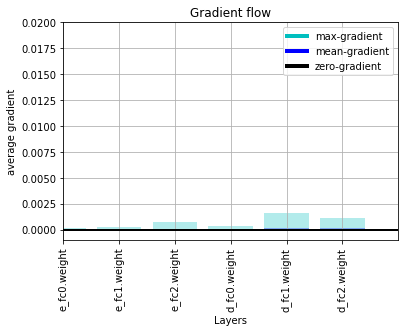

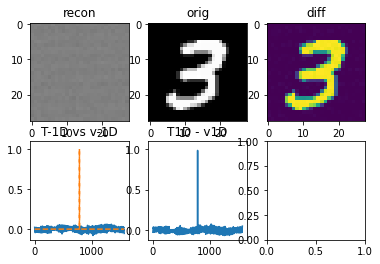

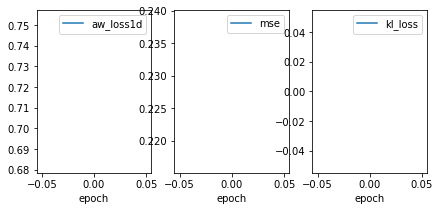

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:28
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:52
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:40
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:34
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:30
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:28
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:26
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:25
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:24
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:23
 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:22
 12% (12 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:16
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.2615976631641388, 'train_awi1d_loss': 0.709201991558075, 'train_kl_loss': 0.0}
 argidx T, v:  783 975


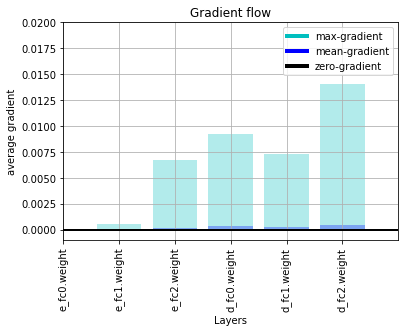

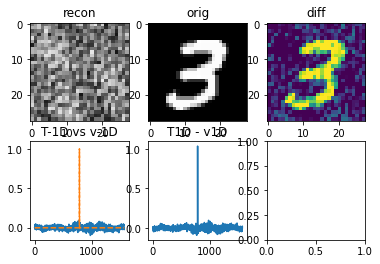

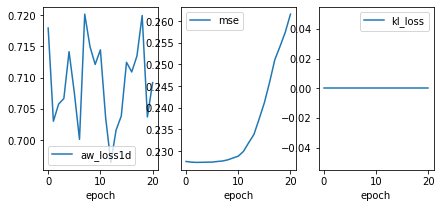

 21% (21 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:22
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:05 ETA:   0:00:22
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:05 ETA:   0:00:21
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:05 ETA:   0:00:20
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:20
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:20
 27% (27 of 100) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:19
 28% (28 of 100) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:19
 29% (29 of 100) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:18
 30% (30 of 100) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:17
 31% (31 of 100) |#######                | Elapsed Time: 0:00:07 ETA:   0:00:17
 32% (32 of 100) |#######                | Elapsed Time: 0:00:07 ETA:   0:00:16
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.3572278320789337, 'train_awi1d_loss': 0.6965884566307068, 'train_kl_loss': 0.0}
 argidx T, v:  783 691


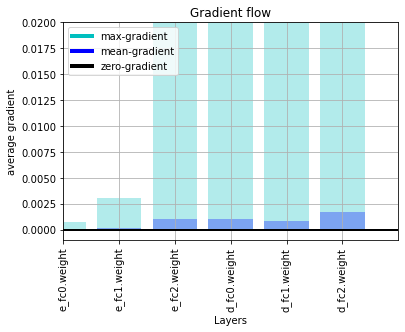

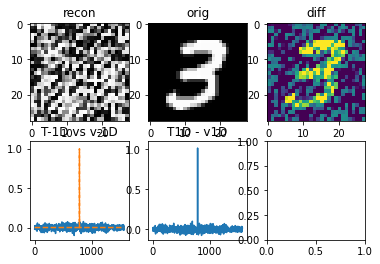

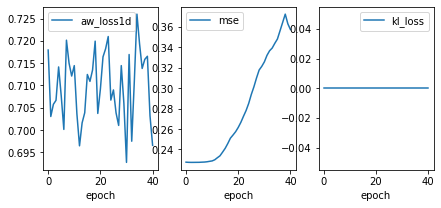

 41% (41 of 100) |#########              | Elapsed Time: 0:00:09 ETA:   0:00:17
 42% (42 of 100) |#########              | Elapsed Time: 0:00:09 ETA:   0:00:16
 43% (43 of 100) |#########              | Elapsed Time: 0:00:10 ETA:   0:00:16
 44% (44 of 100) |##########             | Elapsed Time: 0:00:10 ETA:   0:00:16
 45% (45 of 100) |##########             | Elapsed Time: 0:00:10 ETA:   0:00:16
 46% (46 of 100) |##########             | Elapsed Time: 0:00:10 ETA:   0:00:15
 47% (47 of 100) |##########             | Elapsed Time: 0:00:10 ETA:   0:00:15
 48% (48 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:14
 49% (49 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:13
 50% (50 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:12
 51% (51 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:12
 52% (52 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:09
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.36195817589759827, 'train_awi1d_loss': 0.6990723609924316, 'train_kl_loss': 0.0}
 argidx T, v:  783 981


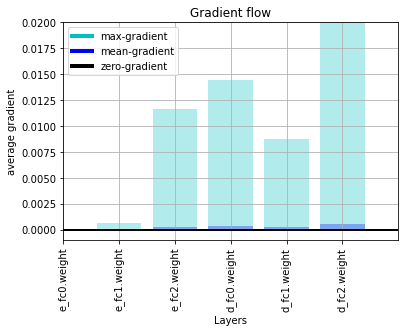

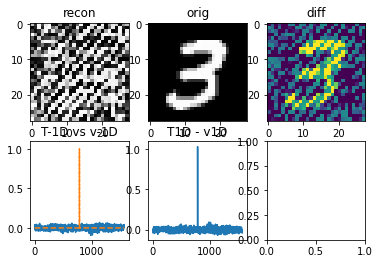

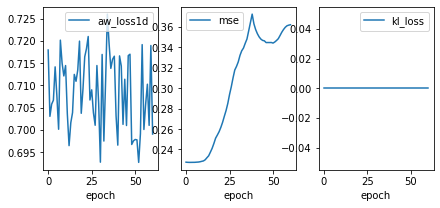

 61% (61 of 100) |##############         | Elapsed Time: 0:00:14 ETA:   0:00:11
 62% (62 of 100) |##############         | Elapsed Time: 0:00:14 ETA:   0:00:11
 63% (63 of 100) |##############         | Elapsed Time: 0:00:14 ETA:   0:00:11
 64% (64 of 100) |##############         | Elapsed Time: 0:00:14 ETA:   0:00:10
 65% (65 of 100) |##############         | Elapsed Time: 0:00:14 ETA:   0:00:10
 66% (66 of 100) |###############        | Elapsed Time: 0:00:15 ETA:   0:00:10
 67% (67 of 100) |###############        | Elapsed Time: 0:00:15 ETA:   0:00:09
 68% (68 of 100) |###############        | Elapsed Time: 0:00:15 ETA:   0:00:09
 69% (69 of 100) |###############        | Elapsed Time: 0:00:15 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:15 ETA:   0:00:07
 71% (71 of 100) |################       | Elapsed Time: 0:00:16 ETA:   0:00:07
 72% (72 of 100) |################       | Elapsed Time: 0:00:16 ETA:   0:00:05
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.27623116970062256, 'train_awi1d_loss': 0.6875988245010376, 'train_kl_loss': 0.0}
 argidx T, v:  783 820


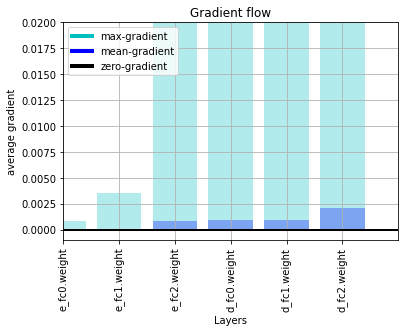

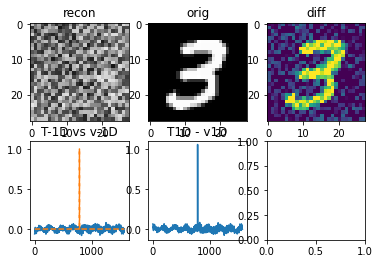

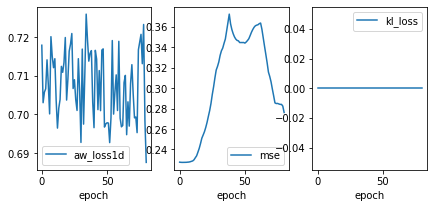

 81% (81 of 100) |##################     | Elapsed Time: 0:00:18 ETA:   0:00:05
 82% (82 of 100) |##################     | Elapsed Time: 0:00:18 ETA:   0:00:04
 83% (83 of 100) |###################    | Elapsed Time: 0:00:18 ETA:   0:00:04
 84% (84 of 100) |###################    | Elapsed Time: 0:00:19 ETA:   0:00:04
 85% (85 of 100) |###################    | Elapsed Time: 0:00:19 ETA:   0:00:03
 86% (86 of 100) |###################    | Elapsed Time: 0:00:19 ETA:   0:00:03
 87% (87 of 100) |####################   | Elapsed Time: 0:00:19 ETA:   0:00:03
 88% (88 of 100) |####################   | Elapsed Time: 0:00:19 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:20 ETA:   0:00:02
 90% (90 of 100) |####################   | Elapsed Time: 0:00:20 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:20 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:20 ETA:   0:00:01
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.3137303292751312, 'train_awi1d_loss': 0.7288361191749573, 'train_kl_loss': 0.0}
 argidx T, v:  783 748


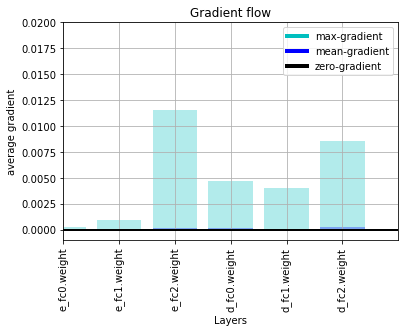

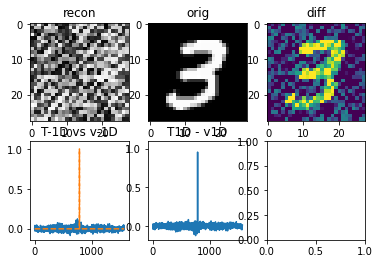

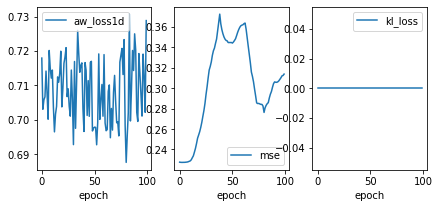

100% (100 of 100) |######################| Elapsed Time: 0:00:22 Time:  0:00:22


In [5]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for n, p in model.named_parameters():
#     if(p.requires_grad) and ("bias" not in n):
#         print(n, p.data.shape)
#         plt.imshow(p.data.numpy())
#         plt.show()

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, 100, switch_at_epoch, vis_frequency=20)



## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


N/A% (0 of 625) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (2 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:01
  0% (4 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:00
  0% (5 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:02
  1% (7 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:01
  1% (8 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:01
  1% (10 of 625) |                       | Elapsed Time: 0:00:00 ETA:   0:01:00
  1% (12 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:00
  2% (14 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:00:59
  2% (16 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:00:59
  2% (17 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:00
  2% (18 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:00
  3% (19 of 625) |                      

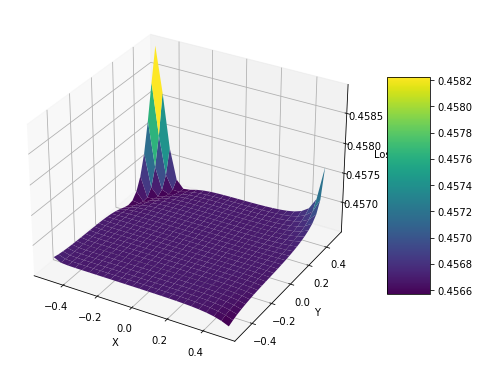

In [14]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23199564218521118, 'train_awi1d_loss': 264.3459167480469, 'train_kl_loss': 521.2367553710938}
 argidx T, v:  783 720


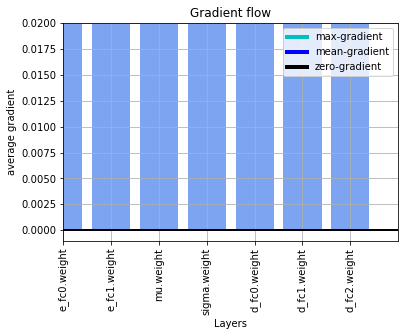

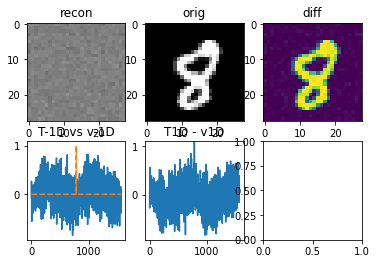

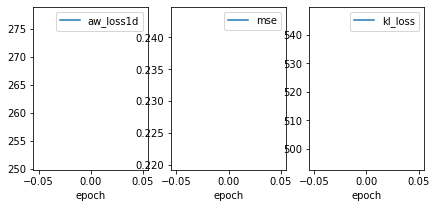

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:37
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:03
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:52
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:47
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:44
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:41
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:30
  9% (9 of 100) |##                      | Elapsed Time: 0:00:03 ETA:   0:00:30
 10% (10 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:29
 11% (11 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:29
 12% (12 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:28
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.23327085375785828, 'train_awi1d_loss': 161.39352416992188, 'train_kl_loss': 785.0758666992188}
 argidx T, v:  783 1219


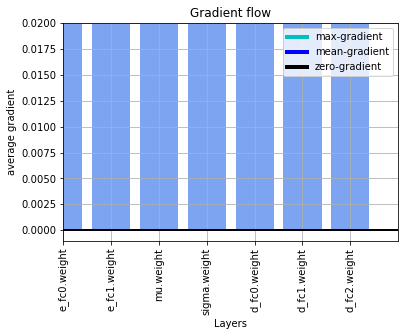

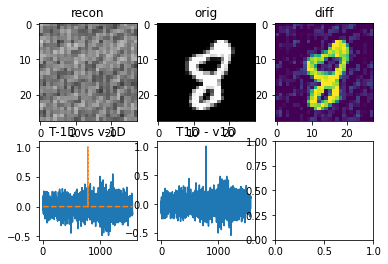

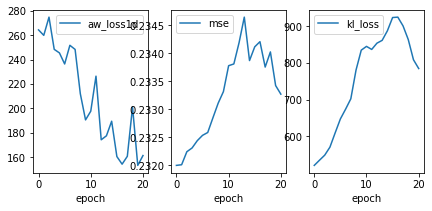

 21% (21 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:39
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:39
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:38
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:35
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:34
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:32
 27% (27 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:31
 28% (28 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:24
 29% (29 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:23
 30% (30 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:23
 31% (31 of 100) |#######                | Elapsed Time: 0:00:11 ETA:   0:00:23
 32% (32 of 100) |#######                | Elapsed Time: 0:00:11 ETA:   0:00:22
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.23494121432304382, 'train_awi1d_loss': 148.4026641845703, 'train_kl_loss': 796.5919799804688}
 argidx T, v:  783 1138


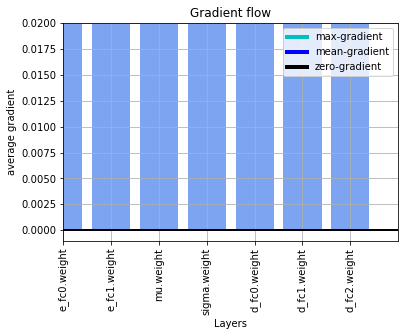

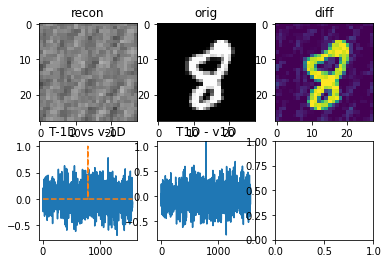

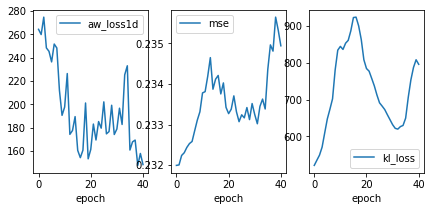

 41% (41 of 100) |#########              | Elapsed Time: 0:00:15 ETA:   0:00:31
 42% (42 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:30
 43% (43 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:29
 44% (44 of 100) |##########             | Elapsed Time: 0:00:16 ETA:   0:00:29
 45% (45 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:26
 46% (46 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:24
 47% (47 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:17
 48% (48 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:17
 49% (49 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:17
 50% (50 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:16
 51% (51 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 52% (52 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.23986345529556274, 'train_awi1d_loss': 143.40695190429688, 'train_kl_loss': 1414.222412109375}
 argidx T, v:  783 521


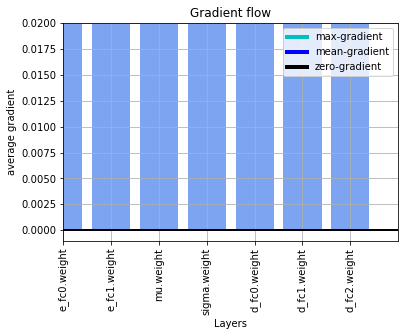

KeyboardInterrupt: 

In [6]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.26504427194595337, 'train_awi1d_loss': 22.57396697998047, 'train_kl_loss': 0.0}
 argidx T, v:  783 626


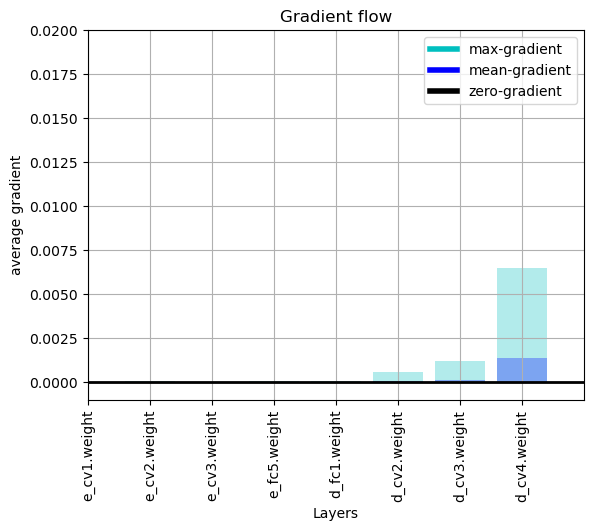

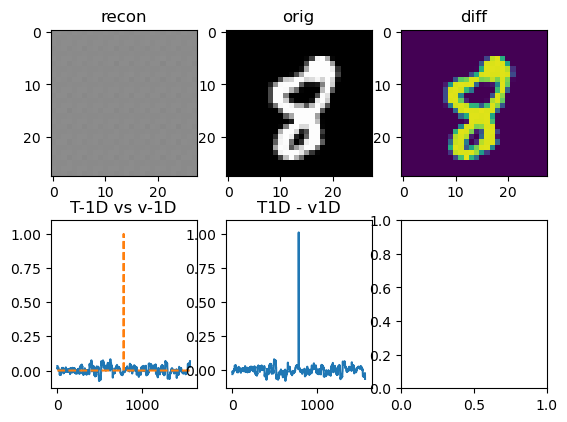

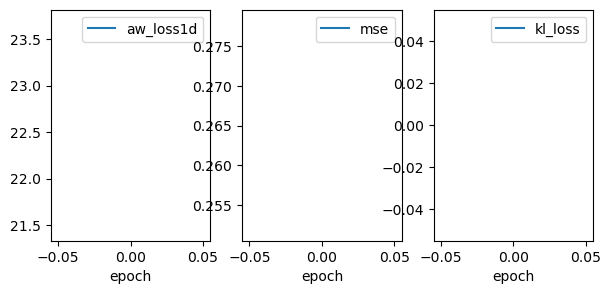

 20% (20 of 100) |####                   | Elapsed Time: 0:00:58 ETA:   0:03:51


 {'epoch': 20, 'train_mse': 0.2649558484554291, 'train_awi1d_loss': 21.234195709228516, 'train_kl_loss': 0.0}
 argidx T, v:  783 978


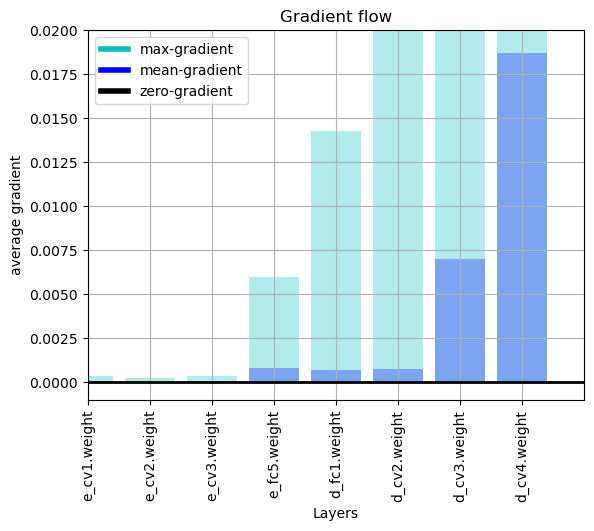

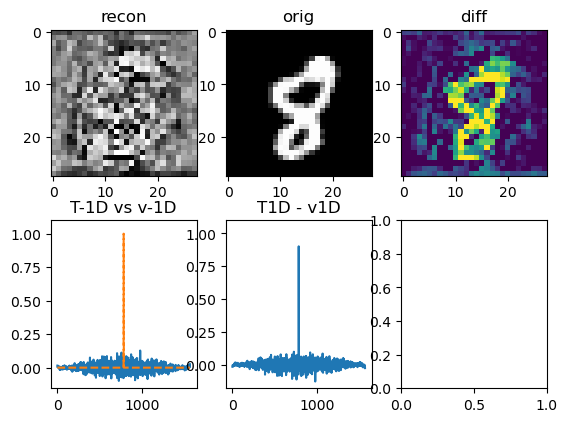

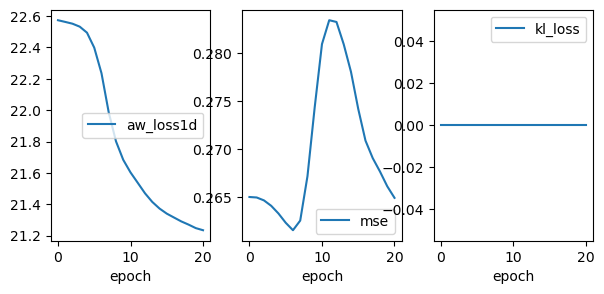

 40% (40 of 100) |#########              | Elapsed Time: 0:01:57 ETA:   0:02:53


 {'epoch': 40, 'train_mse': 0.21971961855888367, 'train_awi1d_loss': 20.53335952758789, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


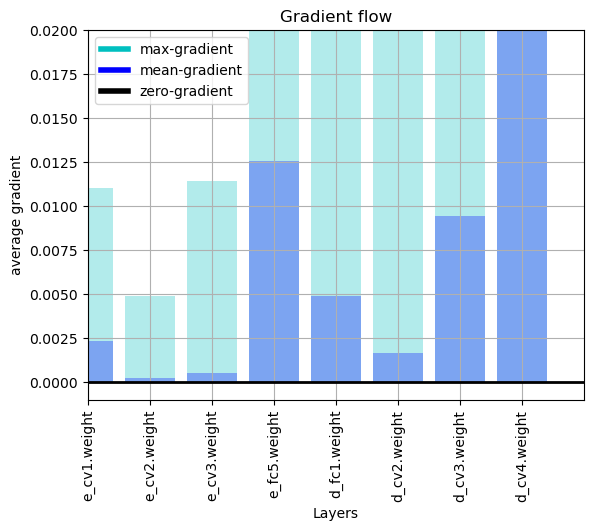

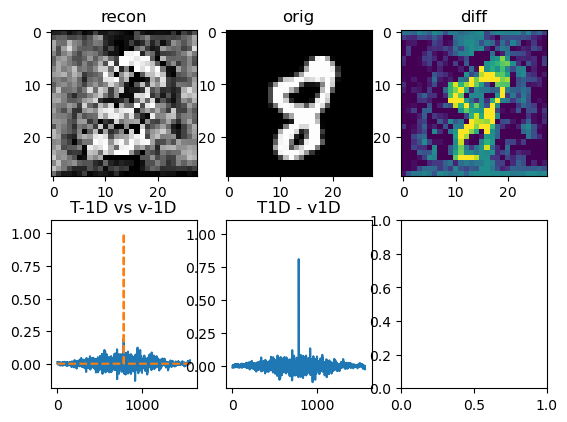

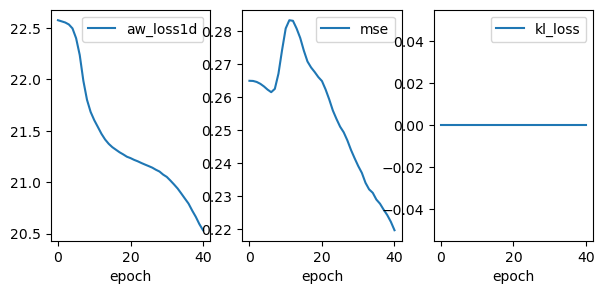

 60% (60 of 100) |#############          | Elapsed Time: 0:02:55 ETA:   0:01:55


 {'epoch': 60, 'train_mse': 0.17401501536369324, 'train_awi1d_loss': 18.52474594116211, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


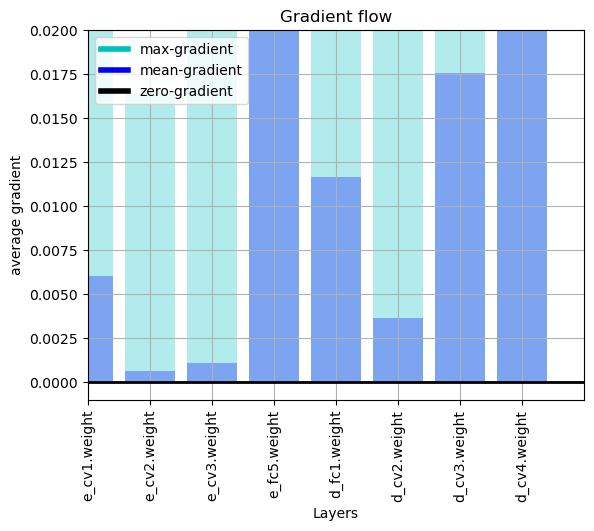

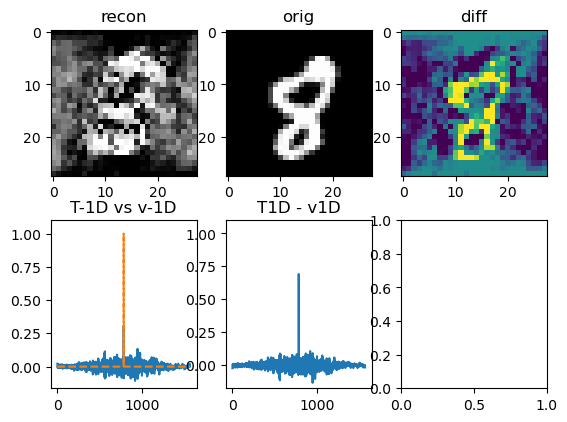

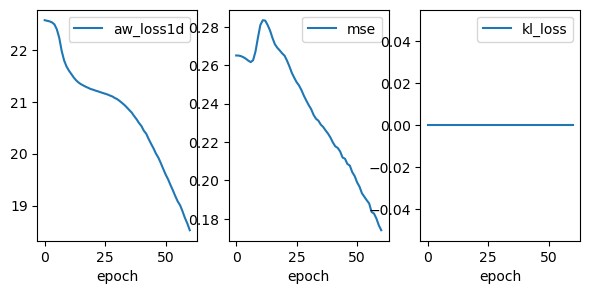

 80% (80 of 100) |##################     | Elapsed Time: 0:03:55 ETA:   0:00:59


 {'epoch': 80, 'train_mse': 0.12443247437477112, 'train_awi1d_loss': 16.579978942871094, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


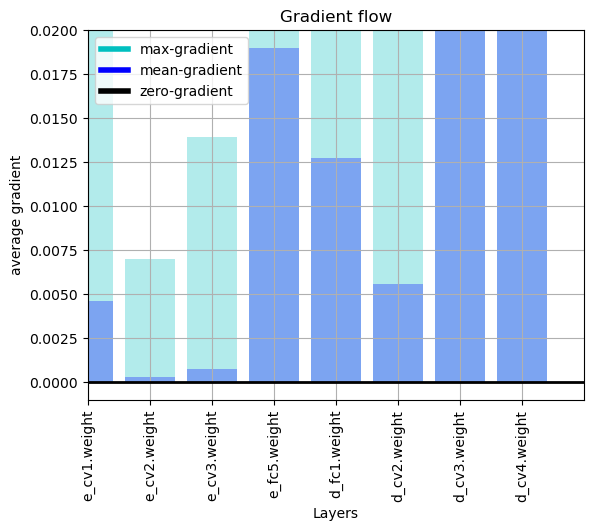

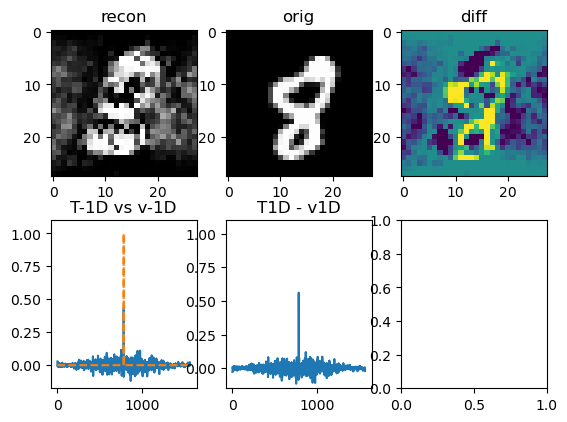

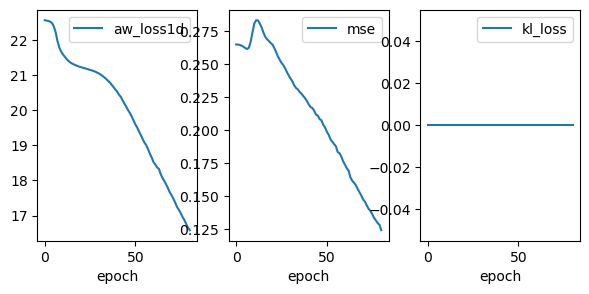

 99% (99 of 100) |###################### | Elapsed Time: 0:04:52 ETA:   0:00:03


 {'epoch': 99, 'train_mse': 0.10168445855379105, 'train_awi1d_loss': 15.240294456481934, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


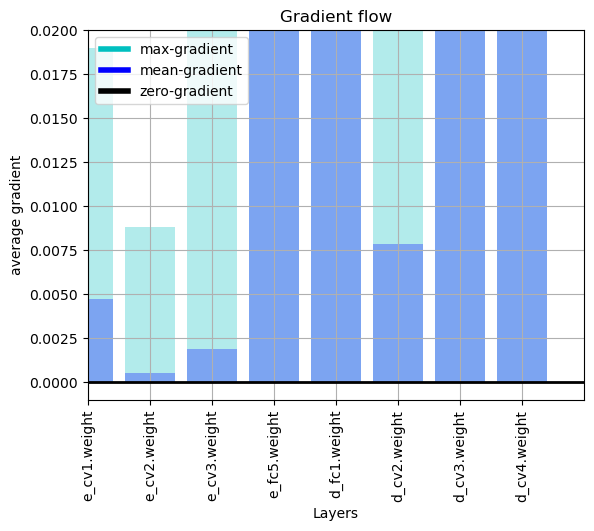

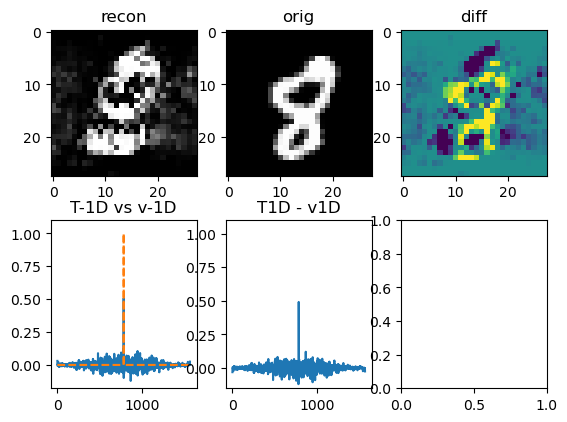

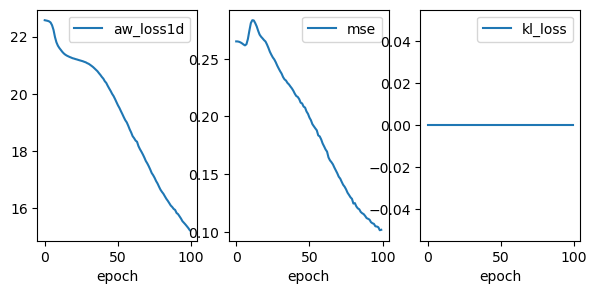

100% (100 of 100) |######################| Elapsed Time: 0:04:53 Time:  0:04:53


In [ ]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23051676154136658, 'train_awi1d_loss': 22.583240509033203, 'train_kl_loss': 517.708984375}
 argidx T, v:  783 626


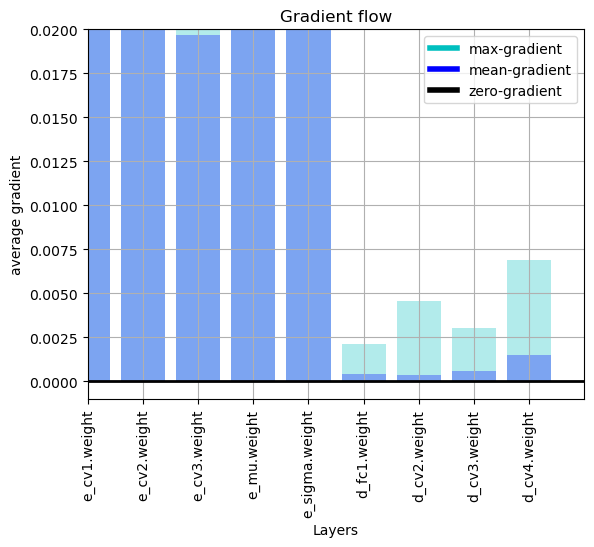

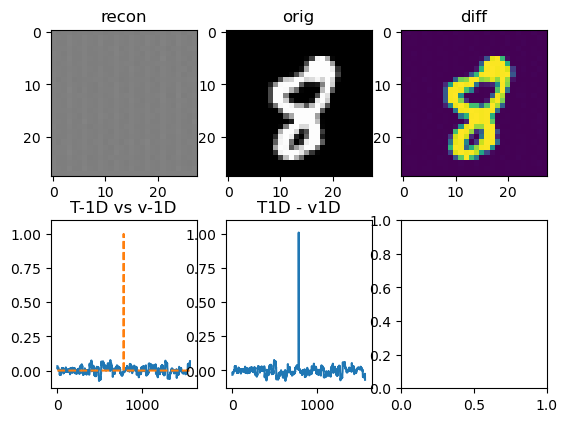

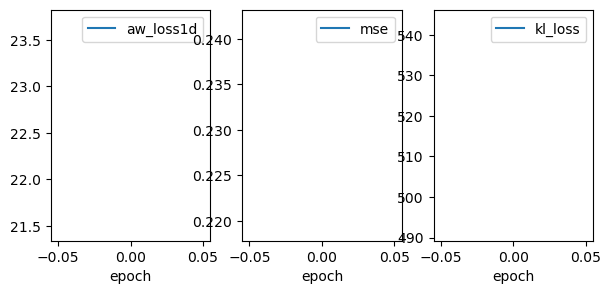

 20% (20 of 100) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:56


 {'epoch': 20, 'train_mse': 0.2209753394126892, 'train_awi1d_loss': 22.082481384277344, 'train_kl_loss': 512.017333984375}
 argidx T, v:  783 528


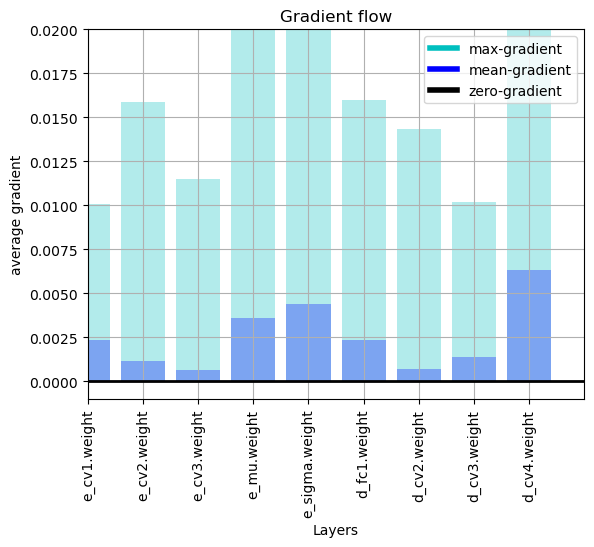

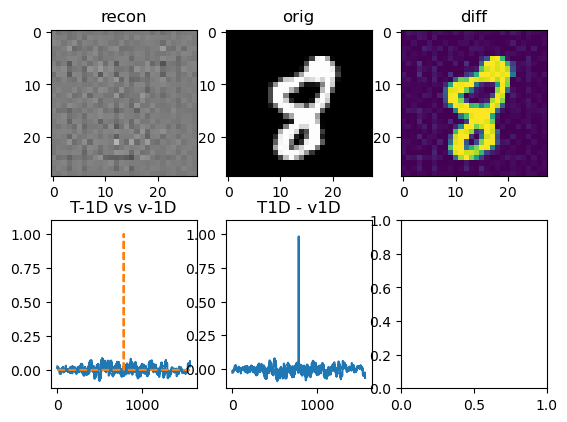

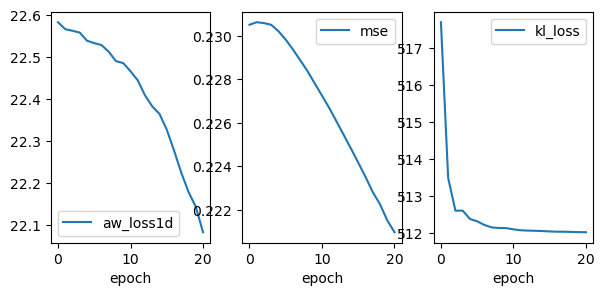

 40% (40 of 100) |#########              | Elapsed Time: 0:01:59 ETA:   0:02:52


 {'epoch': 40, 'train_mse': 0.2162109911441803, 'train_awi1d_loss': 21.386260986328125, 'train_kl_loss': 512.004150390625}
 argidx T, v:  783 950


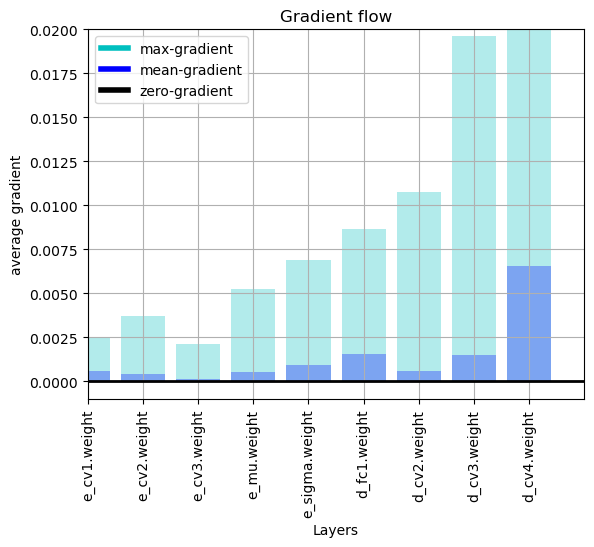

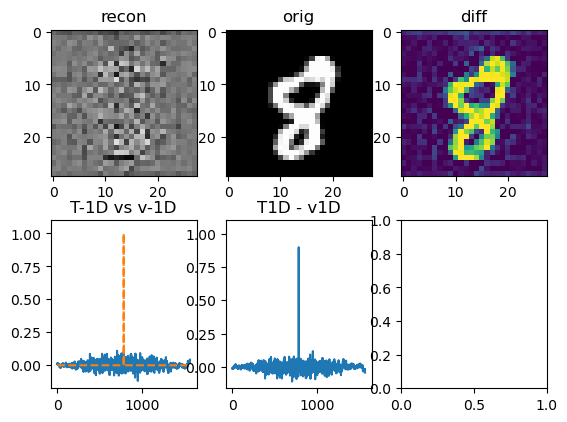

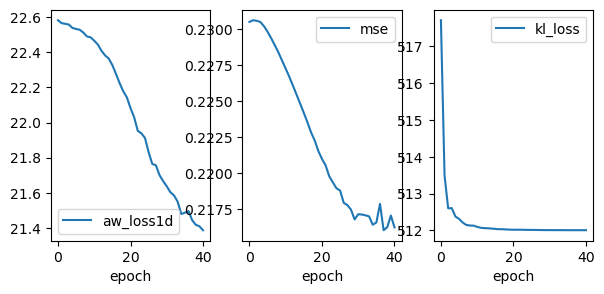

 60% (60 of 100) |#############          | Elapsed Time: 0:02:58 ETA:   0:01:56


 {'epoch': 60, 'train_mse': 0.2127932906150818, 'train_awi1d_loss': 21.164825439453125, 'train_kl_loss': 512.0020751953125}
 argidx T, v:  783 783


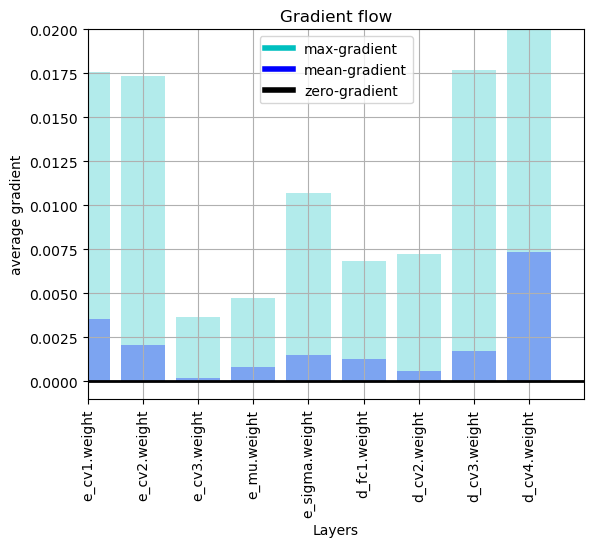

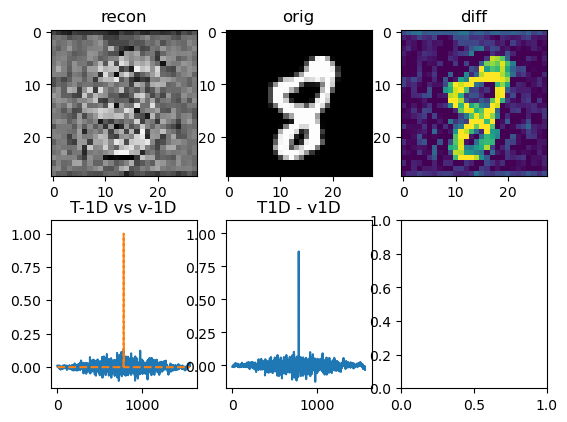

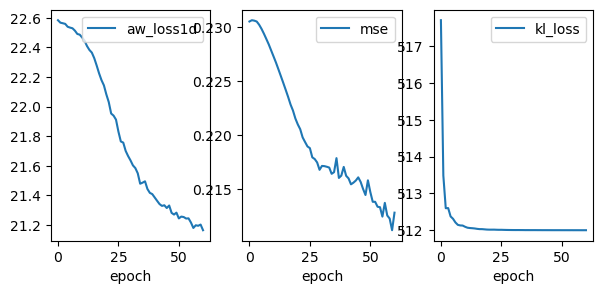

 80% (80 of 100) |##################     | Elapsed Time: 0:03:57 ETA:   0:00:57


 {'epoch': 80, 'train_mse': 0.19917955994606018, 'train_awi1d_loss': 21.057212829589844, 'train_kl_loss': 512.001220703125}
 argidx T, v:  783 783


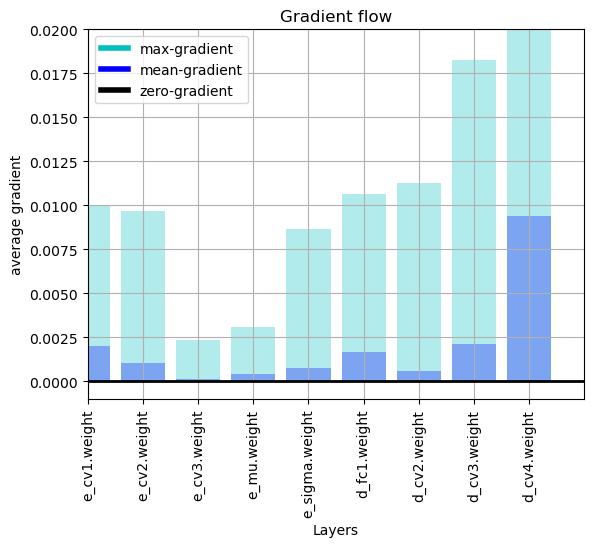

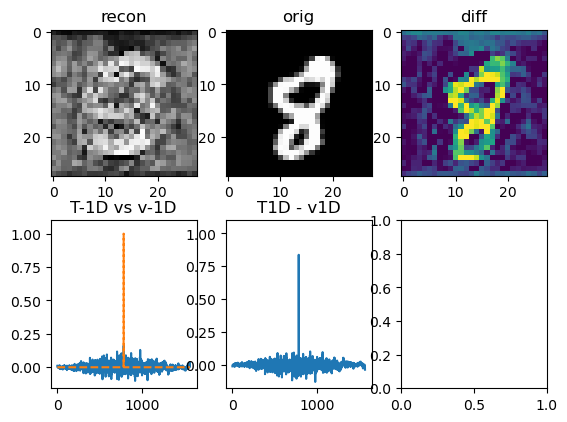

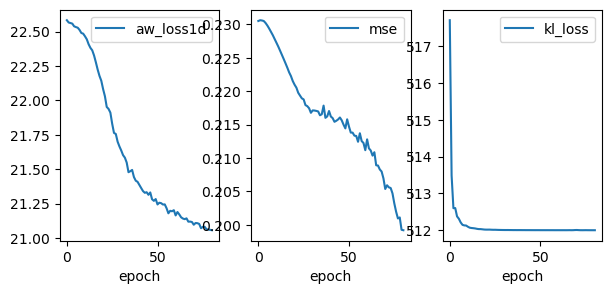

 99% (99 of 100) |###################### | Elapsed Time: 0:04:53 ETA:   0:00:02


 {'epoch': 99, 'train_mse': 0.1809442788362503, 'train_awi1d_loss': 20.9285888671875, 'train_kl_loss': 512.0028686523438}
 argidx T, v:  783 783


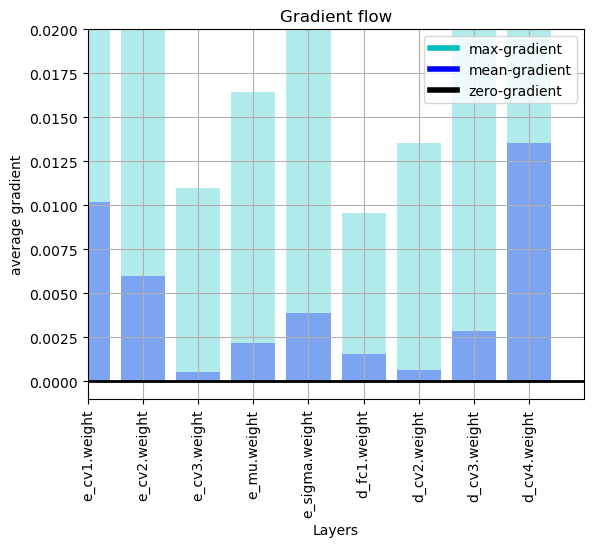

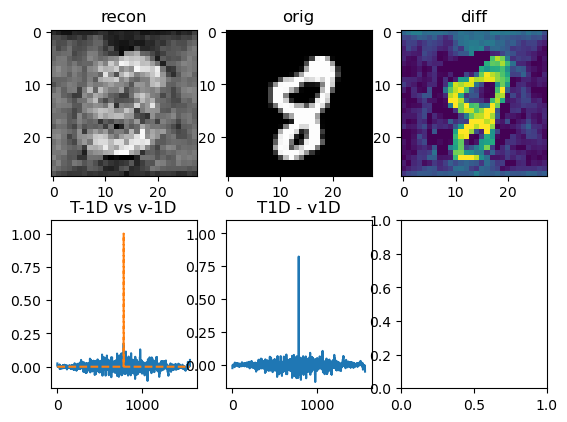

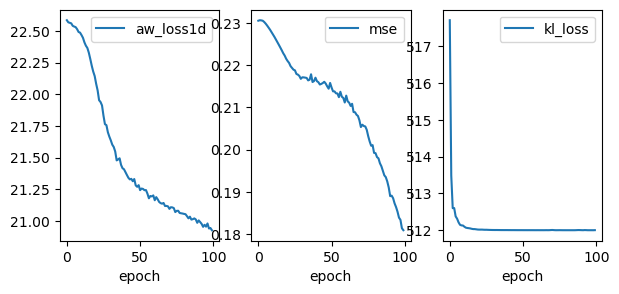

100% (100 of 100) |######################| Elapsed Time: 0:04:54 Time:  0:04:54


In [ ]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)